In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.power import tt_ind_solve_power
import numpy as np
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import norm


In [2]:
df = pd.read_csv('/content/drive/MyDrive/ОБЗОР ВСЕХ МОДУЛЕЙ/data_raw.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27756048 entries, 0 to 27756047
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   client_id   int64 
 2   dt          object
 3   event_type  object
dtypes: int64(2), object(2)
memory usage: 847.0+ MB


In [4]:
df

,Unnamed: 0,client_id,dt,event_type
0,0,6095092,2024-06-20,clicks
1,1,541138559,2024-06-18,clicks
2,2,12189072,2024-06-20,clicks
3,3,674385020,2024-06-20,clicks
4,4,726939378,2024-06-20,clicks
...,...,...,...,...
27756043,27756043,819589730,2024-06-21,views
27756044,27756044,680187923,2024-06-20,views
27756045,27756045,519794764,2024-06-20,views
27756046,27756046,898541720,2024-06-21,views


# 1. Подготовка данных

**Преобразование даты**

In [5]:
# Преобразуем дату в datetime
df['dt'] = pd.to_datetime(df['dt'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27756048 entries, 0 to 27756047
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Unnamed: 0  int64         
 1   client_id   int64         
 2   dt          datetime64[ns]
 3   event_type  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 847.0+ MB


**Функция для очистки - удаление дубликатов**

In [7]:
# удаляем дубликаты
df = df.drop('Unnamed: 0', axis=1, errors='ignore').drop_duplicates(
    subset=['client_id', 'dt', 'event_type'],
    keep='first'
)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8785833 entries, 0 to 27756045
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   client_id   int64         
 1   dt          datetime64[ns]
 2   event_type  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 268.1+ MB


#2. Преобразование данных


In [9]:
# Создаем флаги событий
df['is_view'] = (df['event_type'] == 'views').astype(int)
df['is_click'] = (df['event_type'] == 'clicks').astype(int)
df['is_adds'] = (df['event_type'] == 'adds').astype(int)


# Группируем по пользователю и дате
funnel_df = df.groupby(['client_id', 'dt']).agg({
    'is_view': 'max',  # 1 если был хотя бы 1 просмотр
    'is_click': 'max',  # 1 если был хотя бы 1 клик
    'is_adds': 'max'  # 1 если было хотя бы 1 добавление

}).reset_index()

print(funnel_df.head())

   client_id         dt  is_view  is_click  is_adds
0          1 2024-06-17        1         0        0
1          1 2024-06-19        1         0        0
2          3 2024-06-17        1         1        0
3          3 2024-06-18        1         1        0
4          3 2024-06-19        1         1        1


In [10]:
df

,client_id,dt,event_type,is_view,is_click,is_adds
0,6095092,2024-06-20,clicks,0,1,0
1,541138559,2024-06-18,clicks,0,1,0
2,12189072,2024-06-20,clicks,0,1,0
3,674385020,2024-06-20,clicks,0,1,0
4,726939378,2024-06-20,clicks,0,1,0
...,...,...,...,...,...,...
27756038,69072404,2024-06-19,views,1,0,0
27756039,956460961,2024-06-21,views,1,0,0
27756040,3025462,2024-06-19,views,1,0,0
27756043,819589730,2024-06-21,views,1,0,0


**Распределение типов событий**

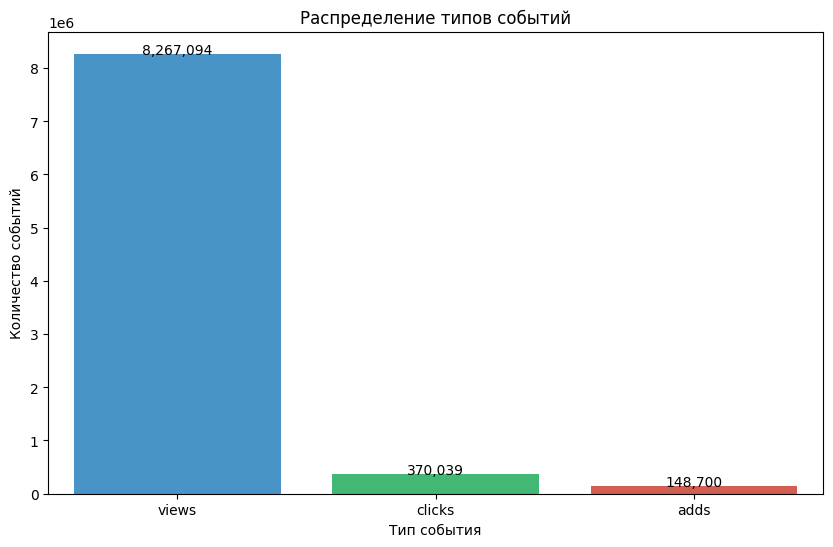

In [11]:

# Определяем пользовательскую палитру
custom_palette = {
    'views': '#3498db',  # Синий для просмотров
    'clicks': '#2ecc71',  # Зеленый для кликов
    'adds': '#e74c3c'    # Красный для добавлений
}

event_counts = df['event_type'].value_counts()

plt.figure(figsize=(10, 6))

# Используем пользовательскую палитру
sns.barplot(x=event_counts.index,
            y=event_counts.values,
            hue=event_counts.index,  # Сохраняем группировку по типам
            palette=custom_palette,  # Применяем пользовательскую палитру
            legend=False)  # Отключаем легенду

plt.title('Распределение типов событий')
plt.ylabel('Количество событий')
plt.xlabel('Тип события')

# Добавляем подписи значений
for i, v in enumerate(event_counts.values):
    plt.text(i, v + 1000, f"{v:,}", ha='center')

plt.show()



**Что было сделано:**

Загрузка данных: Данные были загружены из CSV-файла, содержащего информацию о событиях пользователей (просмотры, клики, добавления).

Преобразование даты: Колонка dt была преобразована в формат datetime для удобства анализа по времени.

Удаление дубликатов: Были удалены дублирующиеся записи по комбинации client_id, dt, и event_type, чтобы избежать искажения результатов.

Создание флагов событий: Были добавлены колонки is_view, is_click, и is_adds, которые принимают значение 1, если событие соответствует типу, и 0 в противном случае.

**Выводы:**

Данные успешно очищены от дубликатов, что улучшает качество анализа.
Создание флагов событий позволяет легко фильтровать и анализировать данные по типам событий.




#**Проверка пользователей**


**Общая статистика**

In [12]:
# Подсчет общего количества записей (событий)
total_events = len(df)

# Подсчет уникальных пользователей
unique_users = df['client_id'].nunique()

# Подсчет событий
total_views = df[df['event_type'] == 'views'].shape[0]
total_clicks = df[df['event_type'] == 'clicks'].shape[0]
total_adds = df[df['event_type'] == 'adds'].shape[0]

# Расчет CTR с защитой от деления на ноль
ctr = total_clicks / total_views if total_views > 0 else 0

cr = total_adds / total_clicks if total_clicks > 0 else 0

# Форматированный вывод
print(f"""
Общая статистика:
- Общее количество записей: {total_events:,}
- Уникальных пользователей: {unique_users:,}
- Всего просмотров: {total_views:,}
- Всего кликов: {total_clicks:,}
- Всего добавлений: {total_adds:,}
- CTR (Click-Through Rate): {ctr:.2%}
- CR (Conversion Rate): {cr:.2%}
""")

# статистика по пользователям
user_stats = df['client_id'].value_counts()
print("\nСтатистика по количеству событий на пользователя:")
print(f"Среднее количество событий на пользователя: {user_stats.mean():.2f}")
print(f"Медианное количество событий на пользователя: {user_stats.median():.0f}")
print(f"Максимальное количество событий у одного пользователя: {user_stats.max():,}")


Общая статистика:
- Общее количество записей: 8,785,833
- Уникальных пользователей: 3,102,736
- Всего просмотров: 8,267,094
- Всего кликов: 370,039
- Всего добавлений: 148,700
- CTR (Click-Through Rate): 4.48%
- CR (Conversion Rate): 40.18%


Статистика по количеству событий на пользователя:
Среднее количество событий на пользователя: 2.83
Медианное количество событий на пользователя: 3
Максимальное количество событий у одного пользователя: 15


**Что было сделано:**

Подсчёт событий: Были подсчитаны общее количество просмотров, кликов и добавлений.

Расчёт метрик:

CTR (Click-Through Rate): отношение кликов к просмотрам.

CR (Conversion Rate): отношение добавлений к кликам.


Анализ уникальных пользователей:

Было подсчитано количество уникальных пользователей, совершивших просмотры, клики и добавления.

**Выводы:**

CTR: 4.48% — показывает, что около 4.48% просмотров приводят к кликам.

CR: 40.18% — показывает, что около 40.18% кликов приводят к добавлениям.

Уникальные пользователи:

Почти все уникальные пользователи (3,102,735 из 3,102,736) совершили хотя бы один просмотр, что говорит о высокой вовлечённости пользователей.

#Детальный анализ по времени


**Данные по дням и типам событий для уникальных клиентов**


АНАЛИЗ СОБЫТИЙ

Количество событий:
- Просмотры: 8,267,094
- Клики: 370,039
- Добавления: 148,700

Уникальные пользователи:
- Всего уникальных: 3,102,736
- Совершали просмотры: 3,102,735
- Совершали клики: 228,491
- Совершали добавления: 90,438

Метрики:
- CTR: 4.48%
- CR: 40.18%

АНАЛИЗ ПО ДНЯМ НЕДЕЛИ

Статистика по дням недели:


,is_view,is_click,is_adds,CTR,CR
day_of_week,,,,,
Monday,1116608,39784,25922,3.56%,65.16%
Tuesday,1841228,87159,26241,4.73%,30.11%
Wednesday,2381898,119870,48523,5.03%,40.48%
Thursday,1828765,85621,24019,4.68%,28.05%
Friday,1098595,37605,23995,3.42%,63.81%


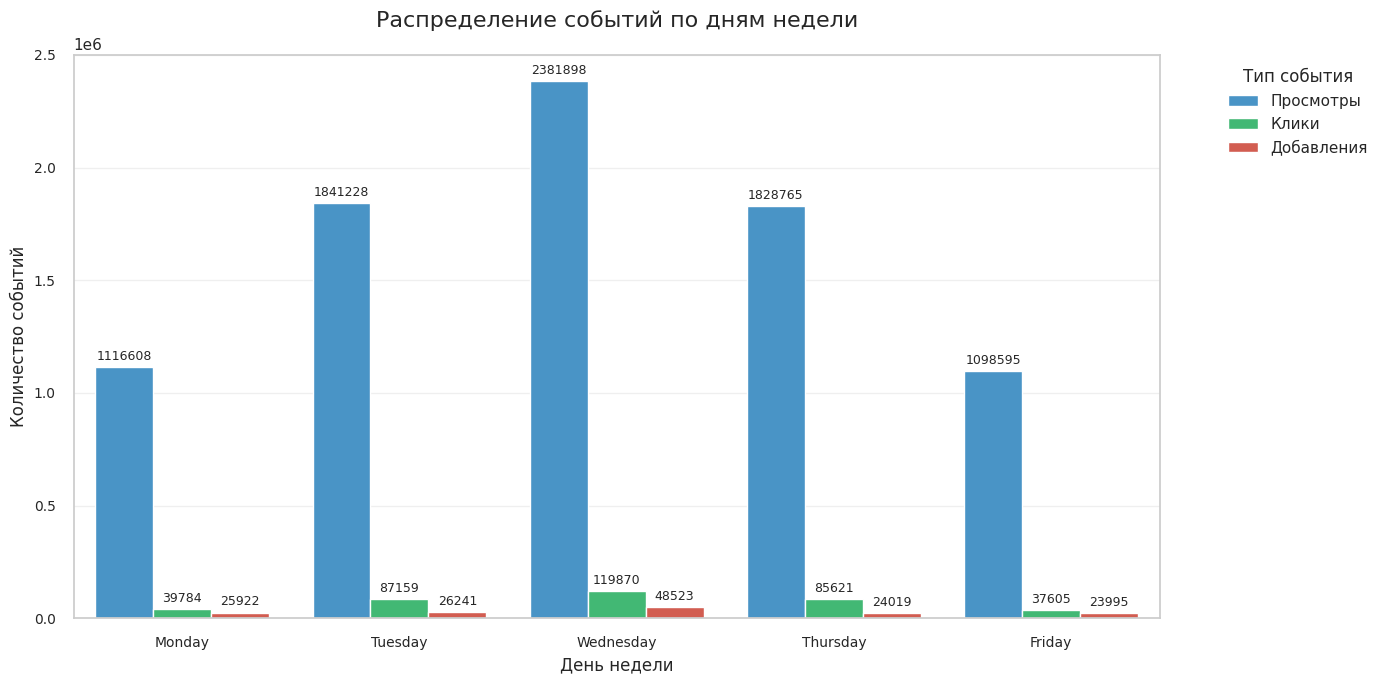

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Установка стиля
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# 1. Подготовка данных: добавление дня недели
if 'day_of_week' not in df.columns:
    df['day_of_week'] = df['dt'].dt.day_name()

# 2. Анализ событий =================================================
print("\n" + "="*50)
print("АНАЛИЗ СОБЫТИЙ")
print("="*50)

events = {
    'Просмотры': df['is_view'].sum(),
    'Клики': df['is_click'].sum(),
    'Добавления': df['is_adds'].sum()
}

unique_users = {
    'Всего уникальных': df['client_id'].nunique(),
    'Совершали просмотры': df[df['is_view'] == 1]['client_id'].nunique(),
    'Совершали клики': df[df['is_click'] == 1]['client_id'].nunique(),
    'Совершали добавления': df[df['is_adds'] == 1]['client_id'].nunique()
}

ctr = events['Клики'] / events['Просмотры'] if events['Просмотры'] > 0 else 0
cr = events['Добавления'] / events['Клики'] if events['Клики'] > 0 else 0

print("\nКоличество событий:")
for event, count in events.items():
    print(f"- {event}: {count:,}")

print("\nУникальные пользователи:")
for metric, count in unique_users.items():
    print(f"- {metric}: {count:,}")

print(f"\nМетрики:")
print(f"- CTR: {ctr:.2%}")
print(f"- CR: {cr:.2%}")

# 3. Анализ по дням недели =========================================
print("\n" + "="*50)
print("АНАЛИЗ ПО ДНЯМ НЕДЕЛИ")
print("="*50)

# Упорядочиваем дни недели
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

# Группировка и подготовка данных для визуализации (уникальные пользователи)
try:
    weekly_dynamics = df.groupby(['day_of_week', 'event_type'], observed=True)['client_id'].nunique().unstack(fill_value=0)
    weekly_dynamics = weekly_dynamics.reindex(day_order)
    weekly_melted = weekly_dynamics.reset_index().melt(
        id_vars='day_of_week',
        var_name='event_type',
        value_name='user_count'
    )
    if weekly_melted.empty:
        raise ValueError("Нет данных для визуализации после группировки")
except Exception as e:
    print(f"\nОшибка при подготовке данных: {str(e)}")
    raise

# Группировка и подготовка данных для визуализации (события)
weekday_stats = df.groupby('day_of_week', observed=True)[['is_view', 'is_click', 'is_adds']].sum()
weekday_stats['CTR'] = weekday_stats['is_click'] / weekday_stats['is_view']
weekday_stats['CR'] = weekday_stats['is_adds'] / weekday_stats['is_click']

print("\nСтатистика по дням недели:")
display(weekday_stats.style.format('{:,.0f}').format({'CTR': '{:.2%}', 'CR': '{:.2%}'}))

# Кастомные палитры
custom_palette_users = {
    'views': '#3498db',
    'clicks': '#2ecc71',
    'adds': '#e74c3c'
}

custom_palette_events = {
    'is_view': '#3498db',
    'is_click': '#2ecc71',
    'is_adds': '#e74c3c'
}

# Визуализация событий
melted_data = weekday_stats.reset_index().melt(
    id_vars='day_of_week',
    value_vars=['is_view', 'is_click', 'is_adds'],
    var_name='event_type',
    value_name='count'
)

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=melted_data,
    x='day_of_week',
    y='count',
    hue='event_type',
    palette=custom_palette_events,
    width=0.8
)
plt.title('Распределение событий по дням недели', fontsize=16, pad=20)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=9, padding=3, fmt='%.0f')
legend_labels = {'is_view': 'Просмотры', 'is_click': 'Клики', 'is_adds': 'Добавления'}
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=[legend_labels.get(l, l) for l in _],
    title='Тип события',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Общее количество событий по дням**

In [14]:
# Подсчет общего количества событий по дням
daily_events = df.groupby('dt').size().reset_index(name='total_events')

# Среднее количество событий в день
avg_daily_events = daily_events['total_events'].mean()
print(f'Среднее количество событий в день: {avg_daily_events:,.2f}')

# Медианное количество событий
median_daily_events = daily_events['total_events'].median()
print(f'Медианное количество событий в день: {median_daily_events:,.2f}')

# Общее количество уникальных пользователей
total_unique_users = df['client_id'].nunique()
print(f'Общее количество уникальных пользователей: {total_unique_users:,}')

# Распределение по типам событий
event_type_distribution = df['event_type'].value_counts(normalize=True) * 100
print('Распределение типов событий (%):')
print(event_type_distribution.round(2))

Среднее количество событий в день: 1,757,166.60
Медианное количество событий в день: 1,938,405.00
Общее количество уникальных пользователей: 3,102,736
Распределение типов событий (%):
event_type
views     94.10
clicks     4.21
adds       1.69
Name: proportion, dtype: float64


**Когортный анализ**

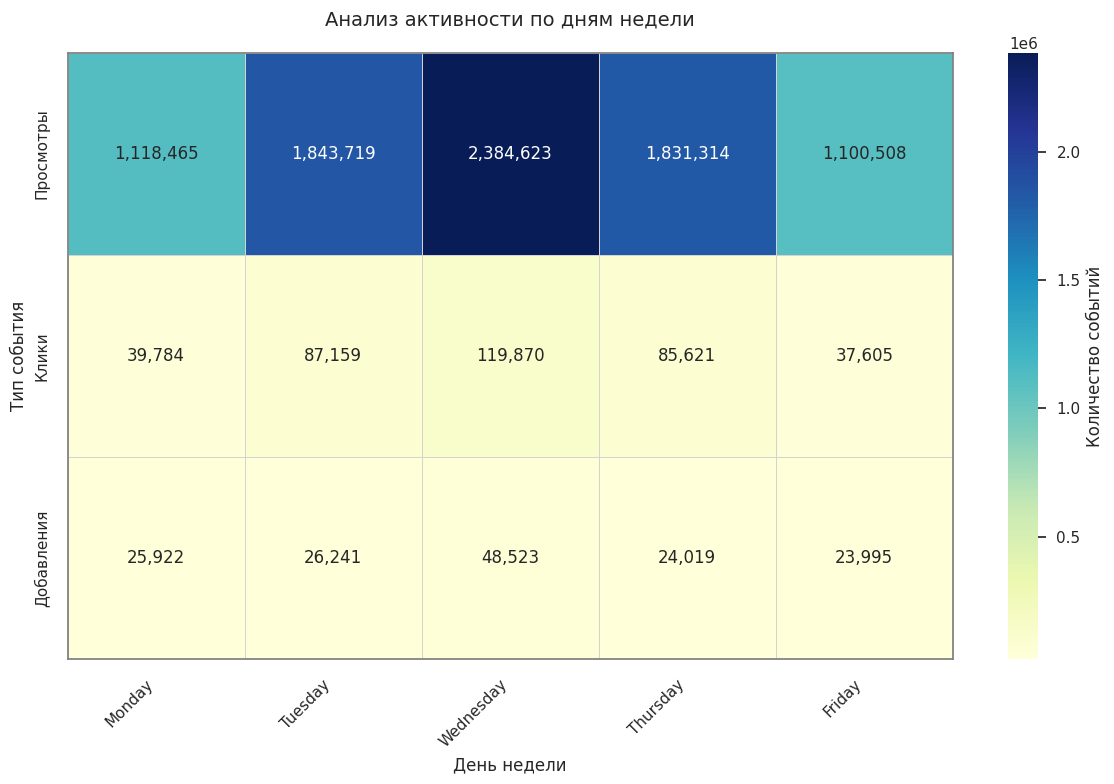

In [16]:

# Группируем по дню недели с явным указанием observed=True
cohort_data = df.groupby('day_of_week', observed=True).agg({
    'is_view': lambda x: df.loc[x.index, 'client_id'].nunique(),
    'is_click': 'sum',
    'is_adds': 'sum'
})

# Упорядочиваем дни недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
cohort_data = cohort_data.reindex(days_order)

# Переименовываем столбцы для лучшей читаемости
cohort_data.columns = ['Просмотры', 'Клики', 'Добавления']

# Создаем фигуру с настройками
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    cohort_data.T,  # Транспонируем для лучшего отображения
    annot=True,
    fmt=',d',
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='lightgray',
    cbar_kws={'label': 'Количество событий'}
)

# Настраиваем оформление
plt.title('Анализ активности по дням недели', pad=20, fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Тип события', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Добавляем разделители
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('gray')

plt.tight_layout()
plt.show()

**Воронка событий**

In [17]:

# Подсчитаем количество каждого типа событий
event_counts = df[['is_view', 'is_click', 'is_adds']].sum().reset_index()
event_counts.columns = ['event_type', 'count']
event_counts['event_type'] = event_counts['event_type'].map({
    'is_view': 'Просмотры',
    'is_click': 'Клики',
    'is_adds': 'Добавления'
})

# Рассчитаем проценты
total = event_counts['count'].iloc[0]
event_counts['percentage'] = (event_counts['count'] / total * 100).round(2)

# Создадим воронку с использованием Plotly
fig = go.Figure(go.Funnel(
    y=event_counts['event_type'],
    x=event_counts['count'],
    textinfo="value+percent initial",
    textposition = "inside",
    marker = {"color": ["#636EFA", "#EF553B", "#00CC96"]}
))

fig.update_layout(
    title='Воронка событий',
    yaxis_title='Тип события',
    xaxis_title='Количество'
)

fig.show()


# Динамика CTR по дням


In [18]:
daily_metrics = df.groupby('dt').agg({
    'client_id': 'nunique',
    'is_view': 'sum',
    'is_click': 'sum',
    'is_adds': 'sum'
}).reset_index()

daily_metrics['CTR'] = daily_metrics['is_click'] / daily_metrics['is_view']

print(daily_metrics)

          dt  client_id  is_view  is_click  is_adds       CTR
0 2024-06-17    1118465  1116608     39784    25922  0.035629
1 2024-06-18    1843719  1841228     87159    26241  0.047337
2 2024-06-19    2384623  2381898    119870    48523  0.050325
3 2024-06-20    1831314  1828765     85621    24019  0.046819
4 2024-06-21    1100508  1098595     37605    23995  0.034230


**Визуализация**


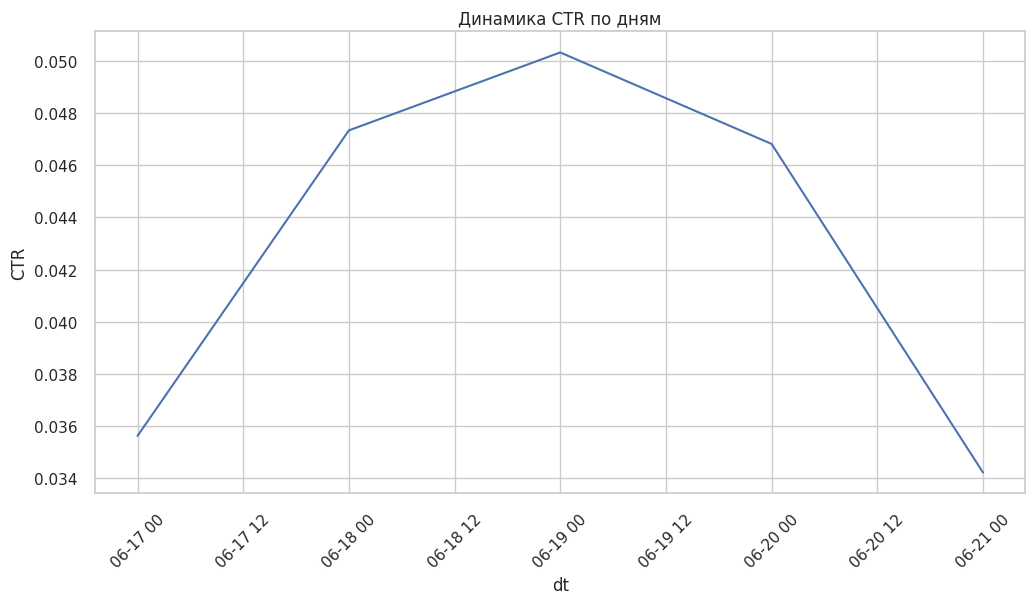

In [19]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_metrics, x='dt', y='CTR')
plt.title('Динамика CTR по дням')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Анализ пользовательских сессий


count    3.102736e+06
mean     2.831641e+00
std      1.523417e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.500000e+01
Name: event_count, dtype: float64


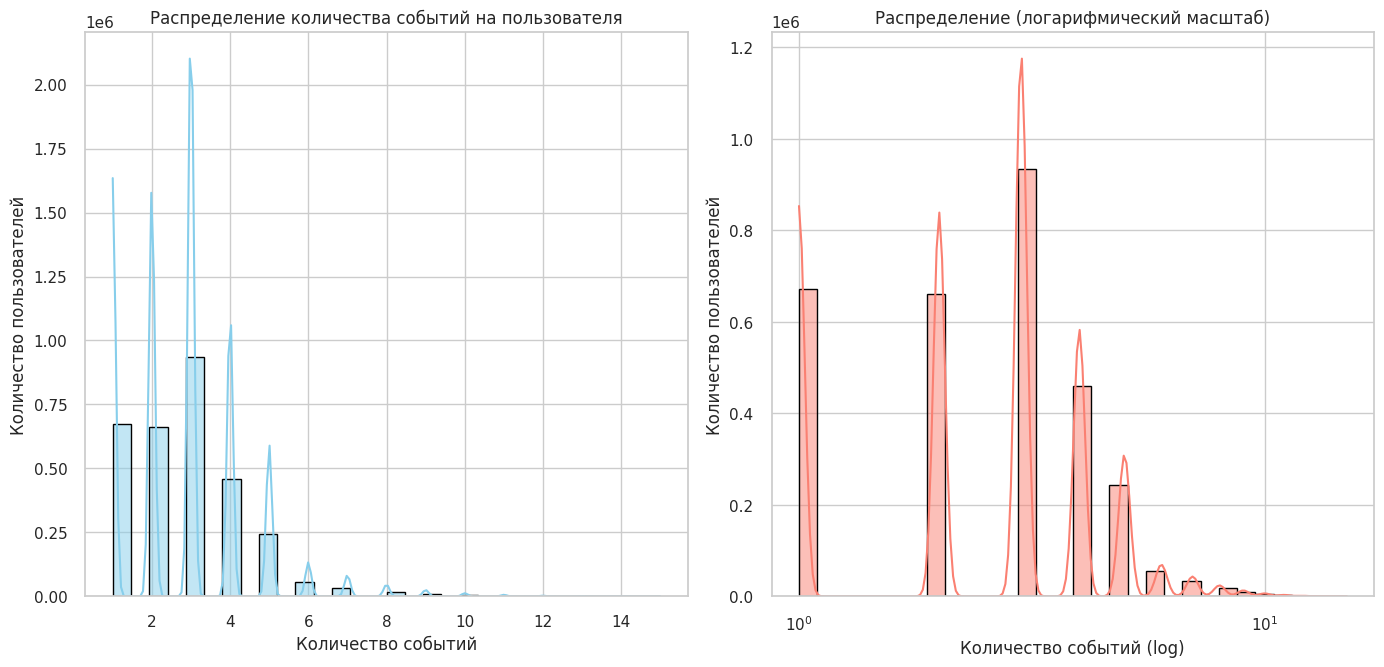


Среднее количество событий на пользователя: 2.83
Медианное количество событий на пользователя: 3.00

Квантили распределения:
0.25    2.0
0.50    3.0
0.75    4.0
0.90    5.0
0.95    5.0
0.99    8.0
Name: event_count, dtype: float64


In [20]:

# Подсчет количества событий на пользователя
user_events = df.groupby('client_id').size().reset_index(name='event_count')

# Статистика по количеству событий
print(user_events['event_count'].describe())

# Создаем гистограмму распределения
plt.figure(figsize=(14, 7))

# Основной график
plt.subplot(1, 2, 1)
sns.histplot(
    user_events['event_count'],
    kde=True,
    bins=30,
    color='skyblue',
    edgecolor='black'
)
plt.title('Распределение количества событий на пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.grid(True)

# График в логарифмическом масштабе
plt.subplot(1, 2, 2)
sns.histplot(
    user_events['event_count'],
    kde=True,
    bins=30,
    log_scale=True,
    color='salmon',
    edgecolor='black'
)
plt.title('Распределение (логарифмический масштаб)')
plt.xlabel('Количество событий (log)')
plt.ylabel('Количество пользователей')
plt.grid(True)

plt.tight_layout()
plt.show()

# Рассчитываем среднее количество событий на пользователя
mean_events = user_events['event_count'].mean()
median_events = user_events['event_count'].median()

print(f"\nСреднее количество событий на пользователя: {mean_events:.2f}")
print(f"Медианное количество событий на пользователя: {median_events:.2f}")

# Дополнительно можно посмотреть распределение по квантилям
quantiles = user_events['event_count'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nКвантили распределения:")
print(quantiles)


#Анализ активности пользователей по времени, дням недели и сессиям

**Что было сделано:**


**Группировка данных по дням недели и датам:**

Данные были сгруппированы по дням недели (day_of_week) и конкретным датам (dt).

Для каждого дня недели и даты были рассчитаны ключевые метрики: CTR (Click-Through Rate) и CR (Conversion Rate).

**CTR (Click-Through Rate)** – отношение количества кликов к количеству просмотров. Показывает, насколько эффективно пользователи взаимодействуют с контентом.

**CR (Conversion Rate)** – отношение количества целевых действий (например, добавлений в корзину) к количеству предыдущих действий (например, кликов). Показывает эффективность конверсии пользователей.


Были подсчитаны среднее и медианное количество событий в день, а также общее количество уникальных пользователей.

**Среднее количество событий на пользователя** – среднее арифметическое количество действий (просмотров, кликов, добавлений), совершённых одним пользователем.

**Медианное количество событий на пользователя** – значение, которое делит всех пользователей на две равные части по количеству событий. Помогает понять типичное поведение пользователей, исключая влияние выбросов.

**Визуализация:**

Построены графики распределения событий по дням недели.

Построен график динамики CTR по датам, чтобы проследить изменения активности пользователей в течение недели.

Построены гистограммы распределения количества событий на пользователя.

**Анализ пользовательских сессий:**

Подсчитано количество событий для каждого пользователя.

Построены гистограммы распределения количества событий на пользователя, включая логарифмический масштаб для выявления выбросов.

**Выводы:**

**Активность по дням недели:**

CTR варьируется от 3.42% (пятница) до 5.03% (среда), что указывает на более высокую активность пользователей в середине недели.

CR также варьируется, достигая максимума в среду (40.48%) и минимума в четверг (28.05%).

**Динамика по датам:**

Среднее количество событий в день: 1,757,167, что говорит о высокой активности пользователей.
График динамики CTR по дням показывает, как изменяется активность пользователей в течение недели, помогая выявить дни с наибольшей и наименьшей вовлечённостью.

**Анализ пользовательских сессий:**

Среднее количество событий на пользователя: 2.83, что говорит о том, что большинство пользователей совершают несколько действий.

Медианное количество событий: 3, что подтверждает вывод о средней активности пользователей.

Гистограммы показывают, что большинство пользователей совершают от 2 до 5 событий, но есть небольшая группа пользователей с высокой активностью (до 15 событий).

# Расчет дисперсии

In [21]:

def calculate_ratio_variance(numerator, denominator):
    # Преобразуем в массивы numpy
    num_array = np.array(numerator)
    denom_array = np.array(denominator)

    # Средние значения
    mean_num = np.mean(num_array)
    mean_denom = np.mean(denom_array)

    # Дисперсии
    var_num = np.var(num_array, ddof=1)
    var_denom = np.var(denom_array, ddof=1)

    # Ковариация
    cov = np.cov(num_array, denom_array, ddof=1)[0, 1]

    # Формула дельта-метода для дисперсии ratio
    ratio_var = (
        (var_num / mean_denom**2) -
        (2 * (mean_num / mean_denom**3) * cov) +
        ((mean_num**2 / mean_denom**4) * var_denom)
    )

    return ratio_var

# Собираем все метрики в один датафрейм
user_metrics = df.groupby('client_id')['event_type'].apply(list).reset_index()

# Создаем колонки с количеством событий для каждого типа
user_metrics['views'] = user_metrics['event_type'].apply(lambda x: x.count('views'))
user_metrics['clicks'] = user_metrics['event_type'].apply(lambda x: x.count('clicks'))
user_metrics['adds'] = user_metrics['event_type'].apply(lambda x: x.count('adds'))  # Добавляем эту строку

# Фильтруем пользователей для CTR
valid_ctr_users = user_metrics[user_metrics['views'] > 0]

# Рассчитываем дисперсию CTR
ctr_variance = calculate_ratio_variance(
    numerator=valid_ctr_users['clicks'],
    denominator=valid_ctr_users['views']
)

print(f"Дисперсия CTR: {ctr_variance:.6f}")

# Фильтруем пользователей для CR
valid_cr_users = user_metrics[user_metrics['clicks'] > 0]

# Рассчитываем дисперсию CR
cr_variance = calculate_ratio_variance(
    numerator=valid_cr_users['adds'],
    denominator=valid_cr_users['clicks']
)

print(f"Дисперсия CR: {cr_variance:.6f}")


Дисперсия CTR: 0.030775
Дисперсия CR: 0.334631


**Что было сделано:**

**Расчёт дисперсии CTR и CR:**

Для каждого пользователя были подсчитаны количество просмотров (views), кликов (clicks) и добавлений (adds).

Использовался дельта-метод для оценки дисперсии CTR и CR, учитывая, что эти метрики являются отношениями (например, CTR = Клики / Просмотры).


**Дисперсия (Variance)** — мера разброса значений относительно среднего.
Показывает, насколько значения метрики (например, CTR или CR) варьируются между пользователями или группами.


**Дельта-метод (Delta Method)** — статистический метод, используемый для оценки дисперсии функции от случайных величин.
В данном случае он применяется для расчёта дисперсии отношений (например, CTR = Клики / Просмотры).

**Выводы:**

Дисперсия CTR: 0.030775

Показывает, что значения CTR среди пользователей имеют умеренный разброс. Это означает, что поведение пользователей в плане кликабельности относительно стабильно, но есть некоторая вариативность.


Дисперсия CR: 0.334631

Более высокая дисперсия CR по сравнению с CTR указывает на значительный разброс в конверсии пользователей из кликов в добавления. Это может быть связано с тем, что добавления в корзину более чувствительны к внешним факторам (например, дизайну страницы, акциям, предложениям).


#MDE

In [22]:

def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """
    Рассчитывает минимальный обнаруживаемый эффект (MDE) для непрерывных метрик.
    mu: среднее значение
    std: стандартное отклонение
    sample_size: общее число участников
    n_groups: число групп (обычно 2)
    target_share: доля участников в контрольной группе
    r: отношение размеров групп (обычно 1)
    alpha: уровень значимости
    beta: 1 - мощность теста
    """
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(1 - beta)

    n1 = int(sample_size * target_share)
    n2 = int(sample_size * (1 - target_share))

    # Формула для относительного MDE
    mde = (z_alpha + z_beta) * std * np.sqrt((1/n1 + 1/(r*n2)))
    return mde

def calculate_mde_for_conversions(baseline, sample_size, alpha=0.05, power=0.8):
    """
    Расчет MDE для бинарных метрик (конверсий).
    baseline: базовая конверсия (например, 0.05)
    sample_size: число пользователей
    """
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)

    # Формула для биномиальной метрики
    mde = (z_alpha + z_beta) * np.sqrt(2 * baseline * (1 - baseline) / sample_size)

    return mde

# Наши данные
unique_users = 3102736

# Расчет для CTR
baseline_ctr = 0.05  # базовый CTR
mde_ctr = calculate_mde_for_conversions(baseline_ctr, unique_users)
print(f"MDE для CTR: {mde_ctr / baseline_ctr * 100:.2f}%")  # в процентах

# Расчет для CR
baseline_cr = 0.02  # базовый CR
mde_cr = calculate_mde_for_conversions(baseline_cr, unique_users)
print(f"MDE для CR: {mde_cr / baseline_cr * 100:.2f}%")  # в процентах

MDE для CTR: 0.98%
MDE для CR: 1.57%


**Что было сделано:**

Расчёт MDE для бинарных метрик (CTR и CR):


**MDE (Minimum Detectable Effect)** — минимальный размер эффекта, который может быть обнаружен статистически значимо при заданном уровне значимости (обычно 5%) и мощности теста (обычно 80%).

**MDE для бинарных метрик** (например, CTR, CR) показывает, насколько должна измениться метрика (в процентах или абсолютных значениях), чтобы тест смог это зафиксировать как статистически значимое изменение.

Уровень значимости (α) — вероятность ошибочно отклонить нулевую гипотезу (обычно 5%).

Мощность теста (1 - β) — вероятность правильно отклонить нулевую гипотезу, если альтернативная гипотеза верна (обычно 80%).

Базовая конверсия (baseline) — текущее значение метрики (например, CTR = 5%).

Размер выборки (sample size) — количество пользователей или наблюдений, участвующих в тесте.

**Выводы:**

MDE для CTR (0.98%) — означает, что для обнаружения статистически значимого изменения CTR, оно должно быть не менее 0.98% от текущего значения. Например, если текущий CTR = 5%, то изменение должно быть не менее 0.049 (или 4.9%) для обнаружения.


MDE для CR (1.57%) — означает, что для обнаружения статистически значимого изменения CR, оно должно быть не менее 1.57% от текущего значения. Например, если текущий CR = 2%, то изменение должно быть не менее 0.0314 (или 3.14%) для обнаружения.


#Таблица значений mde и размеров выборки.

In [23]:

def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r + 2 + 1/r
    mde = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(sample_size * (1 - target_share * (comparisons - 1)))
    return mde, mde * 100 / mu

# Исходные данные
TOTAL_USERS = 3102736
MAX_SAMPLE_SIZE = int(TOTAL_USERS * 0.2)  # 20% от общего числа
STEP_SIZE = int(TOTAL_USERS * 0.05)  # Шаг 5% от общего числа

# Параметры для CTR
baseline_ctr = 0.0198
variance_ctr = 0.008414
std_ctr = np.sqrt(variance_ctr)

# Параметры для CR
baseline_cr = 0.3987
variance_cr = 0.545429
std_cr = np.sqrt(variance_cr)

print("Таблица MDE для CTR:")
print(f"{'Размер выборки':<20}{'MDE (абс)':<20}{'MDE (%)':<20}")
print("-" * 60)

for sample_size in range(STEP_SIZE, MAX_SAMPLE_SIZE + 1, STEP_SIZE):
    mde_abs, mde_pct = get_MDE(
        mu=baseline_ctr,
        std=std_ctr,
        sample_size=sample_size
    )
    print(f"{sample_size:<20}{mde_abs:<20.6f}{mde_pct:<20.2f}")

print("\nТаблица MDE для CR:")
print(f"{'Размер выборки':<20}{'MDE (абс)':<20}{'MDE (%)':<20}")
print("-" * 60)

for sample_size in range(STEP_SIZE, MAX_SAMPLE_SIZE + 1, STEP_SIZE):
    mde_abs, mde_pct = get_MDE(
        mu=baseline_cr,
        std=std_cr,
        sample_size=sample_size
    )
    print(f"{sample_size:<20}{mde_abs:<20.6f}{mde_pct:<20.2f}")


Таблица MDE для CTR:
Размер выборки      MDE (абс)           MDE (%)             
------------------------------------------------------------
155136              0.001305            6.59                
310272              0.000923            4.66                
465408              0.000753            3.80                
620544              0.000652            3.30                

Таблица MDE для CR:
Размер выборки      MDE (абс)           MDE (%)             
------------------------------------------------------------
155136              0.010506            2.64                
310272              0.007429            1.86                
465408              0.006066            1.52                
620544              0.005253            1.32                


**MDE (Minimum Detectable Effect)** — минимальное изменение метрики, которое может быть обнаружено как статистически значимое при заданном уровне значимости (обычно 5%) и мощности теста (обычно 80%).

**MDE (абс)** — абсолютное значение минимального обнаруживаемого эффекта (например, 0.001305 для CTR).

**MDE (%)** — относительное значение минимального обнаруживаемого эффекта в процентах от базовой метрики (например, 6.59% для CTR).

**Размер выборки** — количество пользователей или наблюдений, участвующих в тесте.


**Таблица MDE для CTR:**

Что показывают данные:

MDE (абс) уменьшается с увеличением размера выборки. Например, для выборки в 155136 пользователей MDE (абс) = 0.001305, а для выборки в 620544 пользователей MDE (абс) = 0.000652.
MDE (%) также уменьшается с увеличением размера выборки. Например, для выборки в 155136 пользователей MDE (%) = 6.59%, а для выборки в 620544 пользователей MDE (%) = 3.30%.

**Выводы:**

Чем больше размер выборки, тем меньшее изменение метрики можно обнаружить как статистически значимое.
Для обнаружения изменений CTR на уровне 3.30% необходимо иметь выборку не менее 620544 пользователей.


**Таблица MDE для CR:**

Что показывают данные:

MDE (абс) для CR также уменьшается с увеличением размера выборки. Например, для выборки в 155136 пользователей MDE (абс) = 0.010506, а для выборки в 620544 пользователей MDE (абс) = 0.005253.
MDE (%) для CR уменьшается с увеличением размера выборки. Например, для выборки в 155136 пользователей MDE (%) = 2.64%, а для выборки в 620544 пользователей MDE (%) = 1.32%.

**Выводы:**

Для обнаружения изменений CR на уровне 1.32% необходимо иметь выборку не менее 620544 пользователей.
Увеличение размера выборки позволяет обнаруживать меньшие изменения в метриках, что важно для точного анализа эффективности изменений.



# Подготовка к A/B тесту


Расчет размера выборки и MDE:



In [24]:

# Параметры текущего CTR
baseline_ctr = ctr
std_ctr = np.sqrt(baseline_ctr * (1 - baseline_ctr))  # Стандартное отклонение для пропорции

# Расчет размера выборки для MDE = 20%
effect_size = 0.20 * baseline_ctr
sample_size = tt_ind_solve_power(
    effect_size=effect_size,
    alpha=0.05,
    power=0.8,
    ratio=1.0
)

print(f"""
Параметры теста:
- Базовый CTR: {baseline_ctr:.2%}
- Стандартное отклонение: {std_ctr:.4f}
- Размер выборки на группу (для MDE=20%): {int(sample_size):,}
""")


Параметры теста:
- Базовый CTR: 4.48%
- Стандартное отклонение: 0.2068
- Размер выборки на группу (для MDE=20%): 195,879



**Параметры теста:**

**Базовый CTR (Click-Through Rate): 4.48%**

Это текущее значение конверсии из просмотров в клики. Оно показывает, что в среднем 4.48% пользователей, увидевших контент, совершают клик.


**Стандартное отклонение: 0.2068**

Стандартное отклонение показывает, насколько значения CTR варьируются относительно среднего значения (4.48%). В данном случае разброс значений CTR составляет около 0.2068.

**Размер выборки на группу (для MDE = 20%): 195,879**

Это количество пользователей, необходимое в каждой группе (контрольной и тестовой), чтобы обнаружить изменение CTR на 20% от базового значения (то есть изменение на 0.896%) с заданной статистической мощностью (обычно 80%) и уровнем значимости (обычно 5%).

**Выводы:**

**Чувствительность теста:**

Размер выборки в 195,879 пользователей на группу позволяет обнаружить изменение CTR на 20% от базового значения (4.48%), то есть изменение на 0.896%.
Если реальное изменение CTR меньше 0.896%, тест может не обнаружить его как статистически значимое.

**Планирование экспериментов:**

Для обнаружения меньших изменений CTR (например, 10% или 5%) потребуется увеличить размер выборки.
Если важно обнаруживать даже небольшие изменения, необходимо рассмотреть возможность увеличения выборки или улучшения точности измерений.

**Оптимизация рекламных кампаний:**

Знание MDE и необходимого размера выборки позволяет более эффективно планировать A/B-тесты и оценивать результаты изменений в рекламных кампаниях.
Если изменения в CTR превышают 0.896%, их можно считать статистически значимыми при данном размере выборки